In [23]:
# Import libraries
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import helper
from itertools import product

In [37]:
# Load retention time data
tdata = pd.read_csv("../retention.min.csv.gz")

# Time point
timept = 10000

# Max
MIN = 0
MAX = 63

In [25]:
# Get PBA allocations
pba_allocations_bpc = {1: set(), 2: set()}
for gamma in np.arange(0, 0.0061, 0.0002):
    print("gamma =", gamma)
    lvlcands = {}
    for (lower, upper), d in tdata[(tdata["timept"] == timept) & (tdata["lower"] <= MAX) & (tdata["upper"] >= MIN) & (tdata["upper"] < 64)].groupby(["lower","upper"]):
        lvlcand = d.mean()[["timept","lower","upper","width","successes","failures","reads","sets","resets","cycles","read_bits","set_bits","reset_bits","lvl","time"]].to_dict()
        lvl, cdf = sorted(d["lvl"].values), np.linspace(0.5/len(d), 1-0.5/len(d), len(d)) # symmetric percentile CDF (https://math.stackexchange.com/questions/33488/how-to-calculate-percentile-is-it-possible-to-get-100-percentile)
        try:
            lvlcand["lower_rd"] = int(np.floor(helper.intersection(np.array([0,64]), np.array([gamma,gamma]), np.array(lvl), cdf)[0][0]))
            lvlcand["upper_rd"] = int(np.ceil(helper.intersection(np.array([0,64]), np.array([1-gamma,1-gamma]), np.array(lvl), cdf)[0][0]))
        except IndexError:
            lvlcand["lower_rd"] = min(lvl)
            lvlcand["upper_rd"] = max(lvl)
        lvlcands[(int(lower), int(upper))] = lvlcand

    pba_allocations = []
    cur_upper = -1
    while True:
        cands = [lvlcand for lvlcand in lvlcands.values() if lvlcand["lower_rd"] > cur_upper]
        if cands == []:
            break
        next_cur_upper = min([cand["upper_rd"] for cand in cands])
        pba_allocations.append([(int(cand["lower"]), int(cand["upper"])) for cand in cands if cand["upper_rd"] == next_cur_upper])
        cur_upper = next_cur_upper
    print(pba_allocations)
    if len(pba_allocations) >= 2:
        pba_allocations_bpc[1].update(product(*pba_allocations[:2]))
    if len(pba_allocations) >= 4:
        pba_allocations_bpc[2].update(product(*pba_allocations[:4]))
pba_allocations_bpc

gamma = 0.0
[[(3, 7), (3, 9), (4, 7), (5, 9), (6, 8)], [(36, 44), (37, 41), (38, 41), (38, 44), (39, 42)], [(55, 58)]]
gamma = 0.0002
[[(3, 7), (3, 9), (4, 7), (5, 9), (6, 8)], [(36, 44), (37, 41), (38, 41), (38, 44), (39, 42)], [(55, 58)]]
gamma = 0.0004
[[(3, 7), (3, 9), (4, 7), (5, 9), (6, 8)], [(36, 44), (37, 41), (38, 41), (38, 44), (39, 42)], [(55, 58)]]
gamma = 0.0006000000000000001
[[(3, 7), (3, 9), (4, 7), (5, 9), (6, 8)], [(36, 44), (37, 41), (38, 41), (38, 44), (39, 42)], [(55, 58)]]
gamma = 0.0008
[[(3, 7), (3, 9), (4, 7), (5, 9), (6, 8)], [(37, 41)], [(55, 58)]]
gamma = 0.001
[[(1, 7), (3, 7), (3, 9), (4, 7), (5, 9), (6, 8)], [(37, 41)], [(55, 57)], [(63, 63)]]
gamma = 0.0012000000000000001
[[(1, 7), (6, 8)], [(35, 42), (37, 41)], [(53, 57), (53, 58), (55, 57)], [(63, 63)]]
gamma = 0.0014
[[(1, 7), (6, 8)], [(35, 41), (35, 42), (37, 41)], [(53, 57), (53, 58), (55, 57)], [(63, 63)]]
gamma = 0.0016
[[(1, 7), (6, 8)], [(34, 41), (35, 41), (35, 42), (37, 41)], [(53, 57), (53, 

{1: {((1, 7), (29, 36)),
  ((1, 7), (30, 38)),
  ((1, 7), (31, 38)),
  ((1, 7), (32, 38)),
  ((1, 7), (32, 39)),
  ((1, 7), (32, 41)),
  ((1, 7), (33, 38)),
  ((1, 7), (33, 39)),
  ((1, 7), (33, 40)),
  ((1, 7), (34, 38)),
  ((1, 7), (34, 39)),
  ((1, 7), (34, 40)),
  ((1, 7), (34, 41)),
  ((1, 7), (35, 41)),
  ((1, 7), (35, 42)),
  ((1, 7), (37, 41)),
  ((3, 7), (36, 44)),
  ((3, 7), (37, 41)),
  ((3, 7), (38, 41)),
  ((3, 7), (38, 44)),
  ((3, 7), (39, 42)),
  ((3, 9), (36, 44)),
  ((3, 9), (37, 41)),
  ((3, 9), (38, 41)),
  ((3, 9), (38, 44)),
  ((3, 9), (39, 42)),
  ((4, 7), (32, 39)),
  ((4, 7), (32, 41)),
  ((4, 7), (33, 39)),
  ((4, 7), (33, 40)),
  ((4, 7), (34, 39)),
  ((4, 7), (34, 40)),
  ((4, 7), (34, 41)),
  ((4, 7), (36, 44)),
  ((4, 7), (37, 41)),
  ((4, 7), (38, 41)),
  ((4, 7), (38, 44)),
  ((4, 7), (39, 42)),
  ((5, 7), (29, 36)),
  ((5, 7), (30, 38)),
  ((5, 7), (31, 38)),
  ((5, 7), (32, 38)),
  ((5, 7), (32, 39)),
  ((5, 7), (32, 41)),
  ((5, 7), (33, 38)),
  ((5, 

In [26]:
# Digraph
DG = nx.DiGraph()
DG.add_nodes_from(lvlcands.items())
DG.add_edges_from([(cand1, cand2) for cand1 in lvlcands for cand2 in lvlcands if lvlcands[cand2]["lower_rd"] > lvlcands[cand1]["upper_rd"]])
DG.number_of_nodes(), DG.number_of_edges()

(2017, 194541)

In [38]:
# Get all possible level allocations
allocations = []
for root in [(i,j) for i in range(7) for j in range(MIN,64)]:
  for leaf in [(k,l) for k in range(root[1],MAX+1) for l in range(MAX,64)]:
    print("ROOT", root, "LEAF", leaf)
    try:
      for path in nx.all_simple_paths(DG, root, leaf):
        allocations.append(tuple(path))  
    except nx.NodeNotFound:
       pass
len(allocations)

ROOT (0, 0) LEAF (0, 63)
ROOT (0, 0) LEAF (1, 63)
ROOT (0, 0) LEAF (2, 63)
ROOT (0, 0) LEAF (3, 63)
ROOT (0, 0) LEAF (4, 63)
ROOT (0, 0) LEAF (5, 63)
ROOT (0, 0) LEAF (6, 63)
ROOT (0, 0) LEAF (7, 63)
ROOT (0, 0) LEAF (8, 63)
ROOT (0, 0) LEAF (9, 63)
ROOT (0, 0) LEAF (10, 63)
ROOT (0, 0) LEAF (11, 63)
ROOT (0, 0) LEAF (12, 63)
ROOT (0, 0) LEAF (13, 63)
ROOT (0, 0) LEAF (14, 63)
ROOT (0, 0) LEAF (15, 63)
ROOT (0, 0) LEAF (16, 63)
ROOT (0, 0) LEAF (17, 63)
ROOT (0, 0) LEAF (18, 63)
ROOT (0, 0) LEAF (19, 63)
ROOT (0, 0) LEAF (20, 63)
ROOT (0, 0) LEAF (21, 63)
ROOT (0, 0) LEAF (22, 63)
ROOT (0, 0) LEAF (23, 63)
ROOT (0, 0) LEAF (24, 63)
ROOT (0, 0) LEAF (25, 63)
ROOT (0, 0) LEAF (26, 63)
ROOT (0, 0) LEAF (27, 63)
ROOT (0, 0) LEAF (28, 63)
ROOT (0, 0) LEAF (29, 63)
ROOT (0, 0) LEAF (30, 63)
ROOT (0, 0) LEAF (31, 63)
ROOT (0, 0) LEAF (32, 63)
ROOT (0, 0) LEAF (33, 63)
ROOT (0, 0) LEAF (34, 63)
ROOT (0, 0) LEAF (35, 63)
ROOT (0, 0) LEAF (36, 63)
ROOT (0, 0) LEAF (37, 63)
ROOT (0, 0) LEAF (38, 

417424

In [39]:
# Get all 1-2 bpc allocations
allocations_bpc = {1 : [a for a in allocations if len(a) == 2], 2 : [a for a in allocations if len(a) == 4]}
{k : len(v) for k, v in allocations_bpc.items()}

{1: 10163, 2: 130890}

In [41]:
# Plot BW-BER tradeoff in level allocations
results = []
for bpc in range(1, 2):
    for i, a in enumerate(allocations_bpc[bpc] + list(pba_allocations_bpc[bpc])):
        if i % 10 == 0:
            print(bpc, i)

        rdbounds = [0]
        for lvl1, lvl2 in zip(a[:-1], a[1:]):
            rdbounds.append(int((lvlcands[lvl1]["upper_rd"] + lvlcands[lvl2]["lower_rd"]) // 2))
        rdbounds.append(64)

        times, confmat = [], []
        for i, lvl in enumerate(a):
            # Get the relevant data
            lvldata = tdata[(tdata["timept"] == timept) & (tdata["lower"] == lvl[0]) & (tdata["upper"] == lvl[1])]

            # Compute average time to target level
            times.append(lvldata["cycles"].mean() * 10e-9)

            # Compute the CER for level
            confvec = []
            for rdbound_low, rdbound_high in zip(rdbounds[:-1], rdbounds[1:]):
                confvec.append(lvldata[(lvldata["lvl"] > rdbound_low) & (lvldata["lvl"] <= rdbound_high)].count()[0])
            confmat.append(confvec)
        times, confmat = np.array(times), np.array(confmat)
        
        # Compute overall results
        bw = (48 - np.genfromtxt("../settings/dead_columns.csv", delimiter=",").size) / times.mean() * bpc

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER
        ber = (grayerr * confmat).sum() / confmat.sum()

        # CER
        cer = 1 - confmat.trace() / confmat.sum()

        # Is a PBA allocation
        is_pba = a in pba_allocations_bpc[bpc]

        # Results
        results.append([bpc, a, rdbounds, confmat, bw, ber, cer, is_pba])

# Get dataframe
data = pd.DataFrame(results, columns=["bpc", "allocation", "read_bounds", "confmat", "bw", "ber", "cer", "is_pba"]).sort_values(["ber", "bw"], ascending=[True, False])
data.to_csv("../data/allocation/allocations2.csv", index=False)
data

1 0
1 10
1 20
1 30
1 40
1 50
1 60
1 70
1 80
1 90
1 100
1 110
1 120
1 130
1 140
1 150
1 160
1 170
1 180
1 190
1 200
1 210
1 220
1 230
1 240
1 250
1 260
1 270
1 280
1 290
1 300
1 310
1 320
1 330
1 340
1 350
1 360
1 370
1 380
1 390
1 400
1 410
1 420
1 430
1 440
1 450
1 460
1 470
1 480
1 490
1 500
1 510
1 520
1 530
1 540
1 550
1 560
1 570
1 580
1 590
1 600
1 610
1 620
1 630
1 640
1 650
1 660
1 670
1 680
1 690
1 700
1 710
1 720
1 730
1 740
1 750
1 760
1 770
1 780
1 790
1 800
1 810
1 820
1 830
1 840
1 850
1 860
1 870
1 880
1 890
1 900
1 910
1 920
1 930
1 940
1 950
1 960
1 970
1 980
1 990
1 1000
1 1010
1 1020
1 1030
1 1040
1 1050
1 1060
1 1070
1 1080
1 1090
1 1100
1 1110
1 1120
1 1130
1 1140
1 1150
1 1160
1 1170
1 1180
1 1190
1 1200
1 1210
1 1220
1 1230
1 1240
1 1250
1 1260
1 1270
1 1280
1 1290
1 1300
1 1310
1 1320
1 1330
1 1340
1 1350
1 1360
1 1370
1 1380
1 1390
1 1400
1 1410
1 1420
1 1430
1 1440
1 1450
1 1460
1 1470
1 1480
1 1490
1 1500
1 1510
1 1520
1 1530
1 1540
1 1550
1 1560
1 1570
1 158

,bpc,allocation,read_bounds,confmat,bw,ber,cer,is_pba
3799,1,"((2, 21), (33, 63))","[0, 25, 64]","[[1386, 0], [0, 1344]]",2.229018e+07,0.000000,0.000000,False
3801,1,"((2, 21), (35, 63))","[0, 26, 64]","[[1386, 0], [0, 1344]]",2.229018e+07,0.000000,0.000000,False
2318,1,"((1, 21), (35, 63))","[0, 27, 64]","[[1386, 0], [0, 1344]]",2.220604e+07,0.000000,0.000000,False
5257,1,"((3, 21), (35, 63))","[0, 27, 64]","[[1386, 0], [0, 1344]]",2.216420e+07,0.000000,0.000000,False
3802,1,"((2, 21), (36, 63))","[0, 28, 64]","[[1386, 0], [0, 1344]]",2.203191e+07,0.000000,0.000000,False
...,...,...,...,...,...,...,...,...
6061,1,"((4, 6), (21, 63))","[0, 15, 64]","[[1379, 7], [7, 1337]]",9.273500e+04,0.005128,0.005128,False
39,1,"((0, 2), (27, 63))","[0, 20, 64]","[[1379, 7], [7, 1337]]",8.953236e+04,0.005128,0.005128,False
1595,1,"((1, 3), (27, 63))","[0, 20, 64]","[[1379, 7], [7, 1337]]",8.953236e+04,0.005128,0.005128,False
4606,1,"((3, 5), (25, 63))","[0, 18, 64]","[[1379, 7], [7, 1337]]",8.953236e+04,0.005128,0.005128,False


In [42]:
# Load allocations
data = pd.read_csv("../data/allocation/allocations2.csv", converters={"allocation": eval, "read_bounds": eval}).drop(columns="confmat")
data

,bpc,allocation,read_bounds,bw,ber,cer,is_pba
0,1,"((2, 21), (33, 63))","[0, 25, 64]",2.229018e+07,0.000000,0.000000,False
1,1,"((2, 21), (35, 63))","[0, 26, 64]",2.229018e+07,0.000000,0.000000,False
2,1,"((1, 21), (35, 63))","[0, 27, 64]",2.220604e+07,0.000000,0.000000,False
3,1,"((3, 21), (35, 63))","[0, 27, 64]",2.216420e+07,0.000000,0.000000,False
4,1,"((2, 21), (36, 63))","[0, 28, 64]",2.203191e+07,0.000000,0.000000,False
...,...,...,...,...,...,...,...
10234,1,"((4, 6), (21, 63))","[0, 15, 64]",9.273500e+04,0.005128,0.005128,False
10235,1,"((0, 2), (27, 63))","[0, 20, 64]",8.953236e+04,0.005128,0.005128,False
10236,1,"((1, 3), (27, 63))","[0, 20, 64]",8.953236e+04,0.005128,0.005128,False
10237,1,"((3, 5), (25, 63))","[0, 18, 64]",8.953236e+04,0.005128,0.005128,False


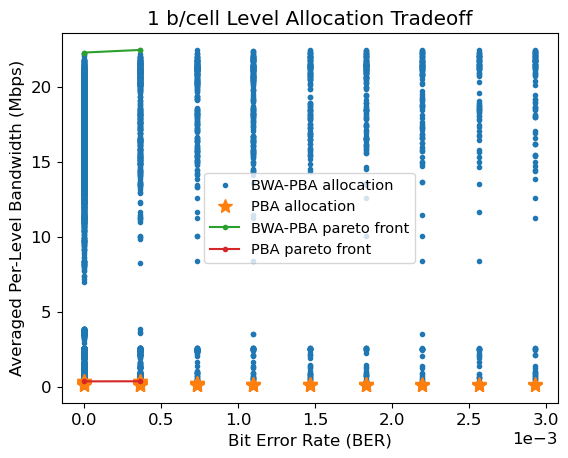

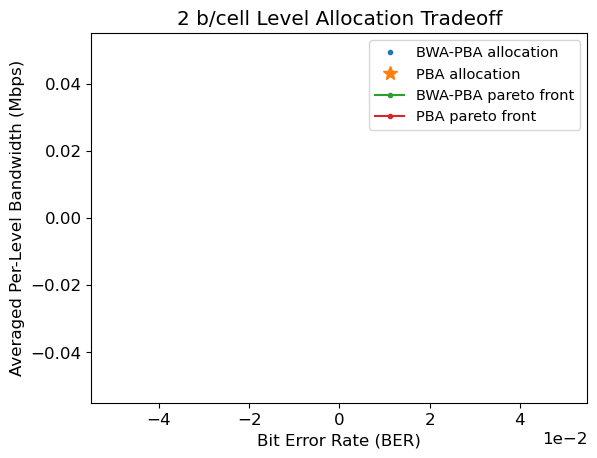

,bpc,allocation,read_bounds,bw,ber,cer,is_pba,bacc
0,1,"((2, 21), (33, 63))","[0, 25, 64]",2.229018e+07,0.000000,0.000000,False,1.000000
6400,1,"((2, 21), (32, 63))","[0, 25, 64]",2.246575e+07,0.000366,0.000366,False,0.999634
5302,1,"((3, 9), (38, 44))","[0, 18, 64]",3.898089e+05,0.000000,0.000000,True,1.000000


In [43]:
# Pareto curve
data["bacc"] = 1 - data["ber"]
best = []
for bpc in range(1, 3):
    data_bpc = data[(data["bpc"] == bpc) & (data["ber"] <= 3e-3)].drop_duplicates(subset=["allocation"])
    data_bpc = data_bpc.drop_duplicates(subset=["ber", "bw"])

    plt.plot(data_bpc["ber"], data_bpc["bw"] / 1e6, ".", label="BWA-PBA allocation")
    plt.plot(data_bpc[data_bpc["is_pba"]]["ber"], data_bpc[data_bpc["is_pba"]]["bw"] / 1e6, "*", markersize=10, label="PBA allocation")

    costs = data_bpc[["bacc", "bw"]].values
    unique_costs = data_bpc[["bacc", "bw"]].drop_duplicates().values #
    is_pareto = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        is_pareto[i] = np.all(np.any(np.delete(costs,i,axis=0)<c, axis=1))
    best.append(data_bpc[is_pareto])
    plt.plot(data_bpc[is_pareto]["ber"], data_bpc[is_pareto]["bw"] / 1e6, '.-', label="BWA-PBA pareto front")
    
    pba_data_bpc = data_bpc[data_bpc["is_pba"]]
    pba_costs = pba_data_bpc[["bacc", "bw"]].values
    pba_is_pareto = np.ones(pba_data_bpc.shape[0], dtype = bool)
    for i, c in enumerate(pba_costs):
        pba_is_pareto[i] = np.all(np.any(np.delete(pba_costs,i,axis=0)<c, axis=1))
    best.append(pba_data_bpc[pba_is_pareto & (pba_data_bpc["ber"] == 0)])
    plt.plot(pba_data_bpc[pba_is_pareto]["ber"], pba_data_bpc[pba_is_pareto]["bw"] / 1e6, '.-', label="PBA pareto front")
    
    plt.ticklabel_format(style="sci", axis="x", scilimits=(0,0))
    plt.title(f"{bpc} b/cell Level Allocation Tradeoff")
    plt.xlabel("Bit Error Rate (BER)")
    plt.ylabel("Averaged Per-Level Bandwidth (Mbps)")
    plt.legend(fontsize=10.5)
    plt.show()
best = pd.concat(best).drop_duplicates(subset=["allocation"])
best

bpc                              1
allocation     ((2, 21), (33, 63))
read_bounds            [0, 25, 64]
bw                 22290180.088345
ber                            0.0
cer                            0.0
is_pba                       False
bacc                           1.0
Name: 0, dtype: object


/home/ember/anaconda3/lib/python3.9/site-packages/matplotlib/transforms.py:2665: RuntimeWarning: invalid value encountered in double_scalars
  [0.0    , y_scale, (-inb*y_scale)],


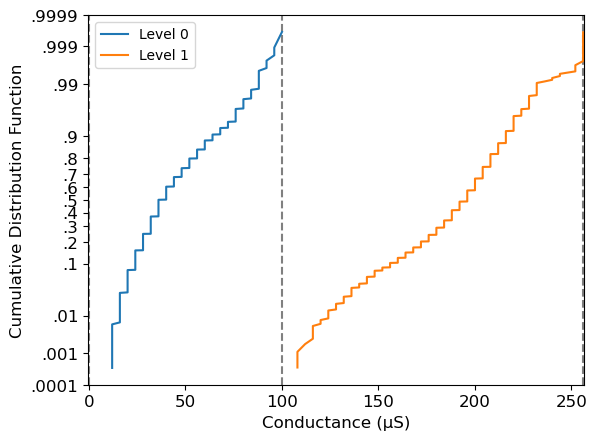

bpc                              1
allocation     ((2, 21), (32, 63))
read_bounds            [0, 25, 64]
bw                 22465753.424658
ber                       0.000366
cer                       0.000366
is_pba                       False
bacc                      0.999634
Name: 6400, dtype: object


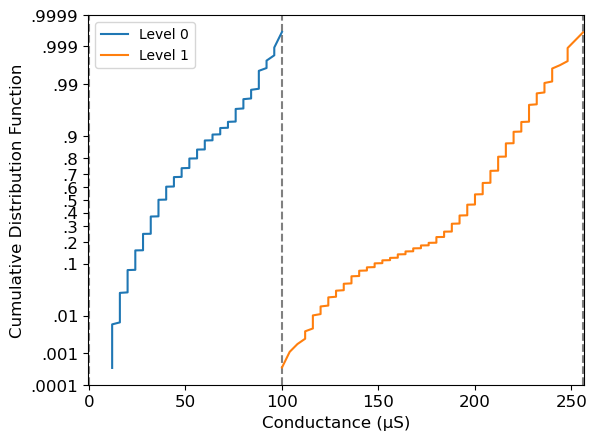

bpc                             1
allocation     ((3, 9), (38, 44))
read_bounds           [0, 18, 64]
bw                  389808.878317
ber                           0.0
cer                           0.0
is_pba                       True
bacc                          1.0
Name: 5302, dtype: object


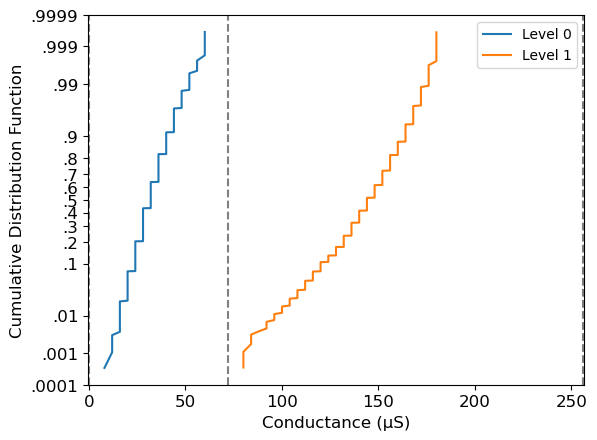

In [44]:
# Visualize allocations
for i, d in best.iterrows():
    plt.xlim(-0.5, 256.5)
    plt.gca().set_yscale("ppf")
    plt.xlabel("Conductance (µS)")
    plt.ylabel("Cumulative Distribution Function")
    print(d)
    for bound in d["read_bounds"]:
        plt.axvline(bound*4, color="gray", linestyle="--")
    for j, lvl in enumerate(d["allocation"]):
        # Get the relevant data
        lvldata = tdata[(tdata["timept"] == timept) & (tdata["lower"] == lvl[0]) & (tdata["upper"] == lvl[1])]

        # Plot distributions
        plt.plot(sorted(lvldata["lvl"].values * 4), np.linspace(0.5/len(lvldata["lvl"].values), 1-0.5/len(lvldata["lvl"].values), len(lvldata["lvl"].values)), label=f"Level {j}")
    plt.legend(fontsize=10)
    plt.show()

In [45]:
# Write out configs
import json
from copy import deepcopy
with open("../settings/config.json") as config_tmpl_file:
    config_tmpl = json.load(config_tmpl_file)

for i, d in best.iterrows():
    with open(f"../settings/opt/{d['bpc']}bpc_{'bwa' if not d['is_pba'] else 'pba'}_{i}.json", "w") as config_outfile:
        config = deepcopy(config_tmpl)
        config["num_levels"] = len(d["allocation"])
        config["level_settings"] = config["level_settings"][:config["num_levels"]]
        config["post_read_setup_cycles"] = 2
        for lvl, ((lower_write, upper_write), read_bound) in enumerate(zip(d["allocation"], d["read_bounds"][1:])):
            config["level_settings"][lvl]["adc_lower_write_ref_lvl"] = lower_write
            config["level_settings"][lvl]["adc_upper_write_ref_lvl"] = upper_write
            config["level_settings"][lvl]["adc_upper_read_ref_lvl"] = min(read_bound, 63)
        json.dump(config, config_outfile, indent=4)